## Workflow for scATAC-Seq data

In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.17.1'

time: 1.41 s (started: 2021-08-21 22:53:44 +02:00)


---
### 1) Fetch and convert data

In [2]:
scarf.fetch_dataset('tenx_10K_pbmc_atacseq', save_path='scarf_datasets')
reader = scarf.CrH5Reader('scarf_datasets/tenx_10K_pbmc_atacseq/data.h5', 'atac')
reader.assayFeats

INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf_vignettes\scarf_datasets\tenx_10K_pbmc_atacseq\data.h5


,ATAC
type,Peaks
start,0
end,90686
nFeatures,90686


time: 11.9 s (started: 2021-08-20 12:04:11 +02:00)


In [3]:
writer = scarf.CrToZarr(reader, zarr_fn=f'scarf_datasets/tenx_10K_pbmc_atacseq/data.zarr', chunk_size=(1000, 2000))
writer.dump(batch_size=1000)

  0%|                                                                                                         …

time: 19.4 s (started: 2021-08-20 12:04:23 +02:00)


---
### 2) Create DataStore and filter cells

In [3]:
ds = scarf.DataStore('scarf_datasets/tenx_10K_pbmc_atacseq/data.zarr', nthreads=4)

time: 47 ms (started: 2021-08-21 22:54:41 +02:00)


INFO: 296 cells flagged for filtering out using attribute ATAC_nCounts
INFO: 260 cells flagged for filtering out using attribute ATAC_nFeatures


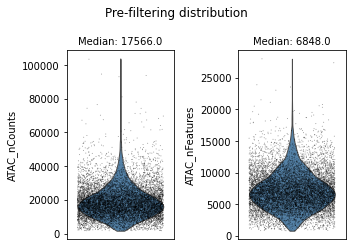

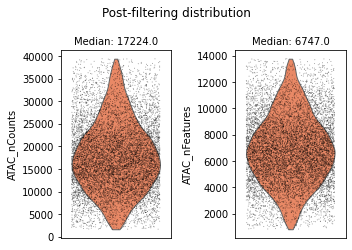

time: 531 ms (started: 2021-08-20 12:10:34 +02:00)


In [13]:
ds.auto_filter_cells()

---
### 3) Feature selection

For scATAC-Seq data, the features are ranked by their [TF-IDF](https://en.wikipedia.org/wiki/Tf-idf) normalized values, summed across all cells. The top n features are marked as `prevalent_peaks` and are used for downstream steps.

In [6]:
ds.mark_prevalent_peaks(top_n=20000)

(ATAC) Calculating peak prevalence across cells:   0%|                                                        …

time: 7.22 s (started: 2021-08-20 12:04:50 +02:00)


---
### 4) KNN graph creation

For scATAC-Seq datasets, Scarf uses TF-IDF normalization. The normalization is automatically performed during the graph building step. The selected features, marked as `prevalent_peaks` in feature metadata, are used for graph creation. For the dimension reduction step, LSI (latent semantic indexing) is used rather than PCA. The rest of the steps are same as for scRNA-Seq data.

In [7]:
ds.make_graph(feat_key='prevalent_peaks', k=11, dims=21, n_centroids=1000)

Writing data to normed__I__prevalent_peaks/data:   0%|                                                        …

C:\Users\parashar\miniconda3\envs\scarf\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Fitting LSI model:   0%|                                                                                      …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.96%
time: 2min 12s (started: 2021-08-20 12:04:57 +02:00)


---
### 5) UMAP reduction and clustering


Non-linear dimension reduction using UMAP and tSNE are performed in the same way as for scRNA-Seq data. Similarly the clustering step is also performed in the same way as for scRNA-Seq data.

In [8]:
ds.run_umap(n_epochs=250, min_dist=0.5, parallel=True)

	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
time: 8.67 s (started: 2021-08-20 12:07:09 +02:00)


In [9]:
ds.run_leiden_clustering(resolution=1)

time: 422 ms (started: 2021-08-20 12:07:18 +02:00)


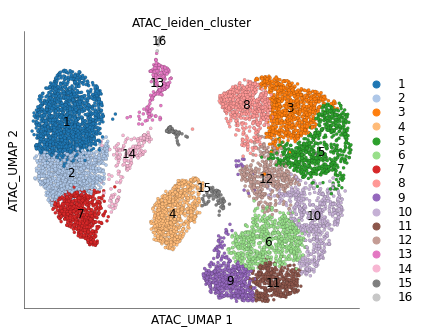

time: 609 ms (started: 2021-08-20 12:07:18 +02:00)


In [10]:
ds.plot_layout(layout_key='ATAC_UMAP', color_by='ATAC_leiden_cluster')

---
### 6) Calculating gene scores

This feature is coming soon..

In [14]:
ds.ATAC.feats.head()

,I,ids,names,I__prevalent_peaks,dropOuts,nCells
0,True,chr1:565163-565491,chr1:565163-565491,False,9619,49
1,True,chr1:569190-569620,chr1:569190-569620,False,9545,123
2,True,chr1:713551-714783,chr1:713551-714783,True,6403,3265
3,True,chr1:752418-753020,chr1:752418-753020,False,9102,566
4,True,chr1:762249-763345,chr1:762249-763345,True,7433,2235


time: 47 ms (started: 2021-08-20 12:10:40 +02:00)


---
That is all for this vignette.